In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stealth-mode-startup-assignment-data/WHATSAAP ASSIGNMENT.mp4
/kaggle/input/stealth-mode-startup-assignment-data/sample cropped video.mp4


### **Import Libraries**

In [3]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython.display as ipd
from ipywidgets import Video
os.chdir('/kaggle/input/stealth-mode-startup-assignment-dataset')

In [4]:
ipd.Video('./sample_cropped_video.mp4', embed= True)

In [23]:
# Load in video capture
def load_video(video_path):
    cap = cv.VideoCapture(video_path)
    video_details = {
        'frame_count': cap.get(cv.CAP_PROP_FRAME_COUNT),
        'fps': cap.get(cv.CAP_PROP_FPS),
        'height': cap.get(cv.CAP_PROP_FRAME_HEIGHT),
        'width': cap.get(cv.CAP_PROP_FRAME_WIDTH)
    }
    print(f"Video details:{video_details}")
    
    ret, img = cap.read()
    cap.release()
    return ret, img, video_details

# Loading video
video_path = 'WHATSAAP_ASSIGNMENT.mp4'
ret, img, video_details = load_video(video_path)

Video details:{'frame_count': 1520.0, 'fps': 23.98989898989899, 'height': 848.0, 'width': 480.0}


In [6]:
## Helper function for plotting opencv images in notebook
def display_img(img, figsize=(5, 5)):
    img_ = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img_)
    ax.axis("off")

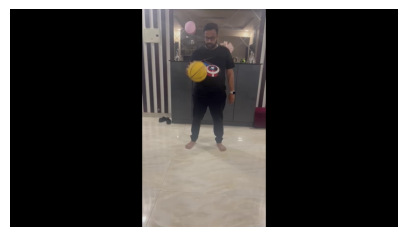

In [7]:
display_img(img)

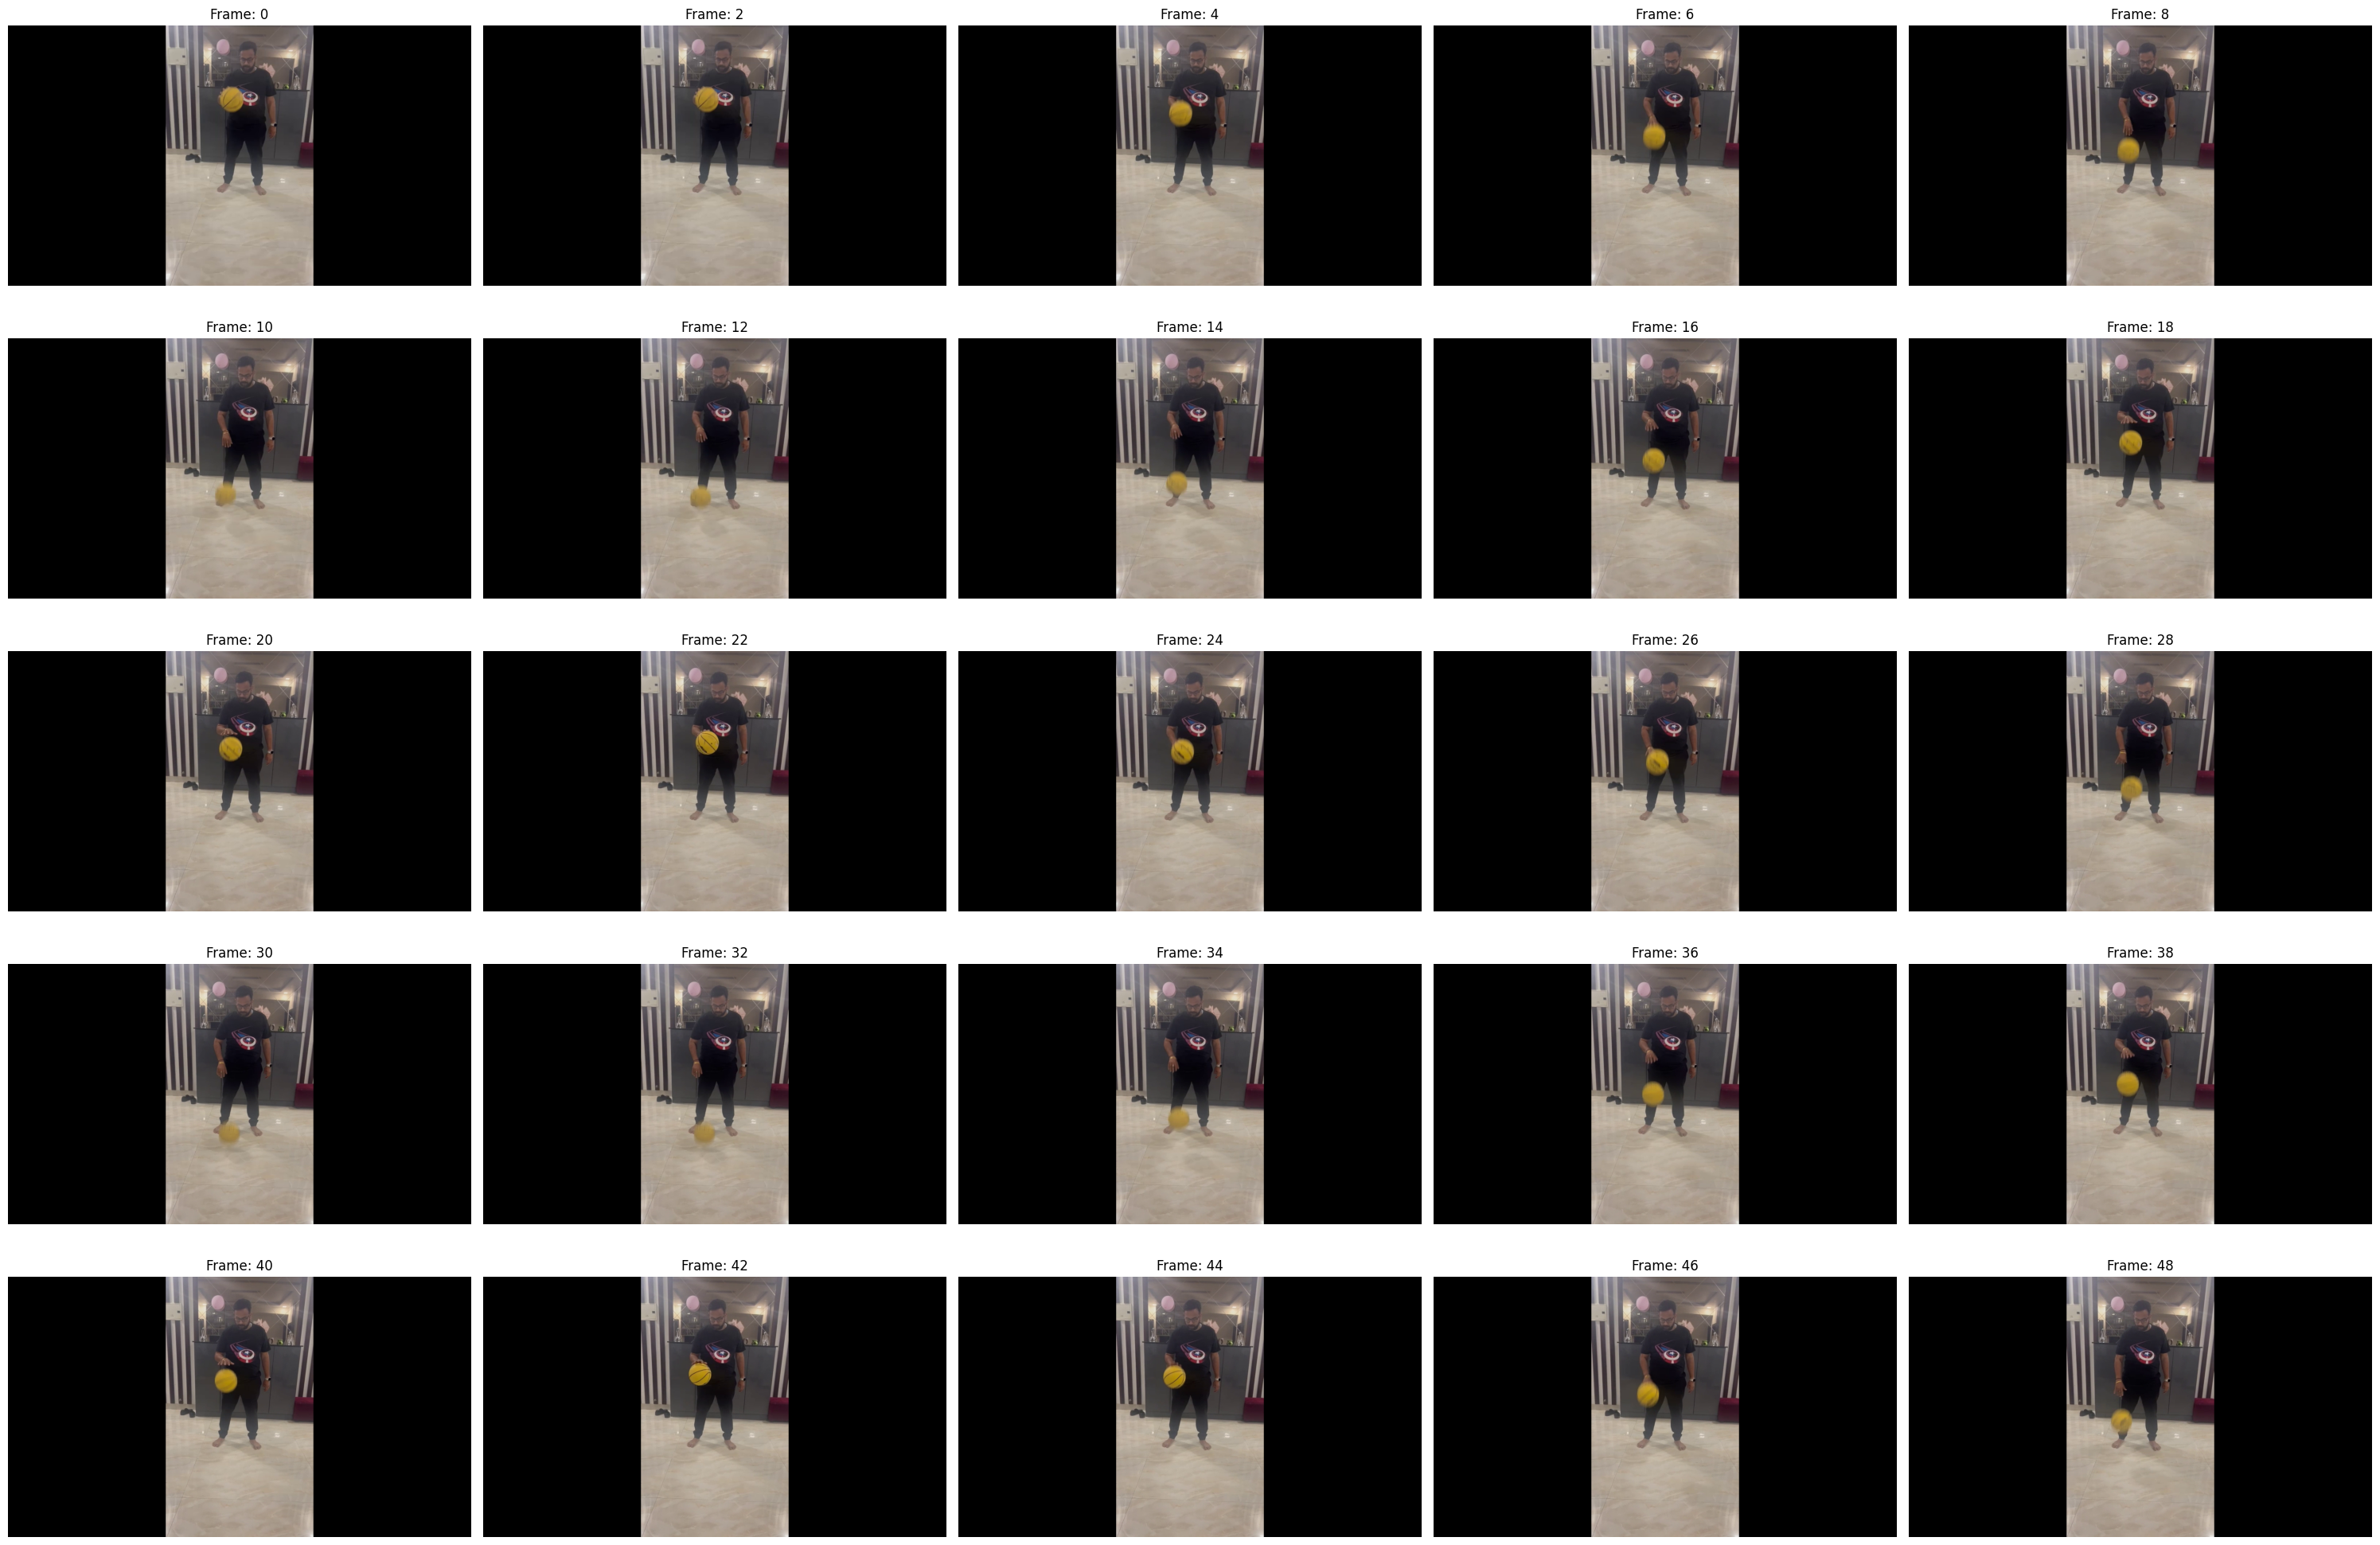

In [8]:
fig, axs = plt.subplots(5, 5, figsize=(30, 20))
axs = axs.flatten()

cap = cv.VideoCapture(video_path)
n_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))

img_idx = 0
for frame in range(n_frames):
    try:
        ret, img = cap.read()
        if ret == False:
            break
        if frame % 2 == 0:
            axs[img_idx].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
            axs[img_idx].set_title(f'Frame: {frame}')
            axs[img_idx].axis('off')
            img_idx += 1
    except:
        break

plt.tight_layout()
plt.show()
cap.release()


In [11]:
# Identifing Circles
def TrackCircles(frame) -> np.array:
    ''' Returns the (x_center, y_center, radius) of the identified circles '''
    # Convert Image to Gray Scale
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise
    blurred = cv.GaussianBlur(gray, (15, 15), 0)

    # Apply HoughCircles to detect circles (basketball)
    circles = cv.HoughCircles(
        blurred,
        cv.HOUGH_GRADIENT,
        dp=1,
        minDist=50,
        param1=50,
        param2=25,
        minRadius=30,
        maxRadius=40
    )
#     circles = np.uint16(np.around(circles))
    
    return circles
    
TrackCircles(img)

In [32]:
import cv2
def CountDribbles(video_path):
    
    cap = cv.VideoCapture(video_path)
    n_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    ball_centers = []
    dribble_count = 1
    down, up = True, False
    p_x_center, p_y_center = 0, 0
    x_center, y_center, radius = None, None, None
    for i in tqdm(range(n_frames-120)):
        ret, image = cap.read()
        
        if ret == False: break

        else:
            hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

            # Define the lower and upper bounds for the yellow color in HSV
            lower_yellow = np.array([20, 100, 100])
            upper_yellow = np.array([30, 255, 255])

            # Create a mask using inRange() to filter out only the yellow pixels
            mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

            # Bitwise-AND operation to extract the yellow region from the original image
            result = cv2.bitwise_and(image, image, mask=mask)
            gray_result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
            non_zero_idx = np.nonzero(gray_result)
            y_center = (non_zero_idx[0][0] + non_zero_idx[0][-1]) // 2
            x_center = (non_zero_idx[1][0] + non_zero_idx[1][-1]) // 2
            ball_centers.append([x_center, y_center])
#             print(f'Frame {i}')
#             circles_info = TrackCircles(frame)
#             print(circles_info)
#             if circles_info is not None:
#                 # Draw the circles on the original frame
#                 circles_info = np.uint16(np.around(circles_info))
# #                 print(circles_info)
#                 for i in circles_info[0, :]:
#                     cv.circle(frame, (i[0], i[1]), i[2], (0, 255, 0), 2)
#                     cv.circle(frame,(i[0], i[1]), 0,(255,0,0), 5)
                
# #             display_img(frame)   
            
#             try:
#                 idx = np.argmax(circle_info, axis = 1)[0]
#             except: 
#                 continue

#             x_center, y_center, radius = circle_info[0][idx[-1]]
            
            if y_center < p_y_center and down:
                down, up = up, down
                dribble_count += 1
#                 print('up+1', y_center, p_y_center)
                
            if y_center > p_y_center and up:
                down, up = up, down
                
                
#                 print('down',  y_center, p_y_center)
                
            p_y_center = y_center
        
    return dribble_count, ball_centers
    

In [33]:
total_dribbles, ball_centers = CountDribbles('WHATSAAP_ASSIGNMENT.mp4')
print('Total Dribbles: ',total_dribbles)

100%|██████████| 1400/1400 [00:06<00:00, 228.58it/s]

Total Dribbles:  128


In [35]:
len(ball_centers)

1400

In [50]:
! git init

/kaggle/input/stealth-mode-startup-assignment-dataset/.git: Read-only file system


fatal: not a git repository (or any parent up to mount point /kaggle/input)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
